In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

In [112]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
dataset_path = './datasets/shrimp/20190425__fried_shrimp_line_reduced/'
images_path = glob.glob(os.path.join(dataset_path, '*.png'))

In [87]:
def load_img(path, gray=False):
    """
    OpenCVを用いて画像を読み込む関数．
    
    Parameters
    ----------
    path : str
        画像へのパス
    gray : True or False
        グレー画像として読み込むかの設定
    """
    if gray:
        img = cv2.imread(path, 0)  # IMREAD_GRAYSCALE
    else:
        img = cv2.imread(path, 1)  # IMREAD_COLOR
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 色空間の変換
    
    return img

## 今回のROI(白用紙の部分)について
画像全体のサイズ…600x800

Region of Interesting(矩形の左上と右下の点座標)

1701~1781まで…(270, 240), (580, 670)あたり

1782~1794まで…(250, 240), (560, 670)あたり

RoIサイズ…310x430

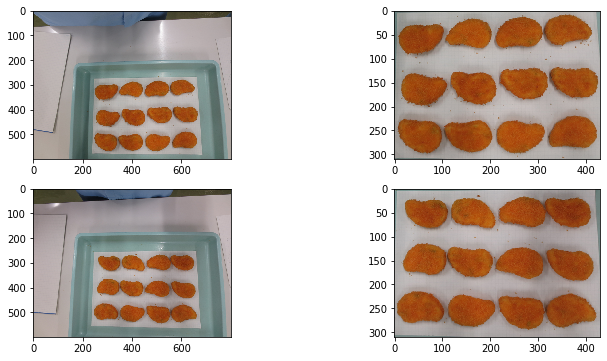

In [88]:
img_01_to_81 = load_img(images_path[0])
RoI_01_to_81 = img_01_to_81[270:580, 240:670, :]
img_rest = load_img(images_path[80])
RoI_rest = img_rest[250:560, 240:670, :]

plt.figure(figsize=(12, 6))
plt.subplot(221); plt.imshow(img_01_to_81)
plt.subplot(222); plt.imshow(RoI_01_to_81)
plt.subplot(223); plt.imshow(img_rest)
plt.subplot(224); plt.imshow(RoI_rest)
plt.show()

## RoI部分の保存

In [53]:
# 保存先ディレクトリがなければ作成
save_dir = './datasets/train/'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [89]:
for i, path in enumerate(images_path):
    img = load_img(path)
    if i < 80:
        RoI = img[270:580, 240:670, :]          # RoI，トレー内の白紙の部分
    else:
        RoI = img[250:560, 240:670, :]
    RoI = cv2.cvtColor(RoI, cv2.COLOR_RGB2BGR)  # opencvの関数で保存するため，再変換
        
    file_name = path[-12:]                      # ファイル名(.pngの部分)
    save_path = os.path.join(save_dir, 'train_' + file_name)
    cv2.imwrite(save_path, RoI)

## マスク画像の作成

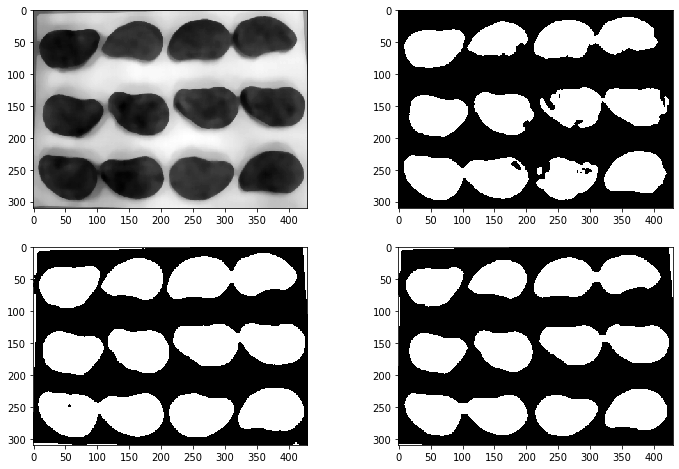

In [153]:
img = load_img(images_path[0], gray=True)  # 57とかヤバい
RoI = img[270:580, 240:670]

RoI = cv2.medianBlur(RoI, 11)
ret, thresh = cv2.threshold(RoI, 102, 255, cv2.THRESH_BINARY)
ada_thresh = cv2.adaptiveThreshold(RoI, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 99, 0)

# 白黒反転
thresh = ~thresh
ada_thresh = ~ada_thresh

# クロージング(内部の黒点除去)してから収縮して結合を切る
kernel_closing = np.ones((5, 5), np.uint8)
kernel_erosion = np.ones((5, 5), np.uint8)
ada_thresh_closing = cv2.morphologyEx(ada_thresh, cv2.MORPH_CLOSE, kernel_closing)
ada_thresh_erosion = cv2.erode(ada_thresh_closing, kernel_erosion, iterations=1)

plt.figure(figsize=(12, 8))
plt.subplot(221); plt.imshow(RoI, cmap='gray')
plt.subplot(222); plt.imshow(thresh, cmap='gray')
plt.subplot(223); plt.imshow(ada_thresh, cmap='gray')
plt.subplot(224); plt.imshow(ada_thresh_erosion, cmap='gray')
plt.show()

## Watershedを試してみる

大津法の二値化によって自動で決定された閾値: 117.0


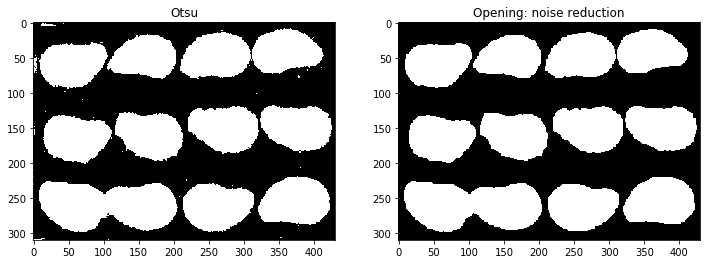

In [218]:
img = load_img(images_path[0], gray=False)  # 57とかヤバい
RoI = img[270:580, 240:670]
RoI_gray = cv2.cvtColor(RoI, cv2.COLOR_BGR2GRAY)

# 大津の閾値処理
thresh, bin_img = cv2.threshold(RoI_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
print('大津法の二値化によって自動で決定された閾値:', thresh)

# ノイズ除去(opening: 収縮後に膨張)
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel, iterations=2)

plt.figure(figsize=(12, 4))
plt.subplot(121); plt.imshow(bin_img, cmap='gray'); plt.title('Otsu')
plt.subplot(122); plt.imshow(opening, cmap='gray'); plt.title('Opening: noise reduction')
plt.show()

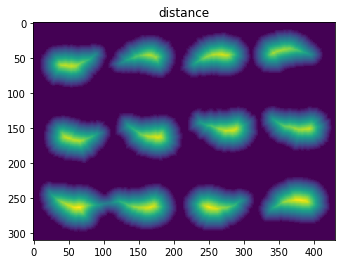

In [217]:
# 距離変換を行う(オブジェクトと背景の距離を出す)
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
plt.imshow(dist_transform)
plt.title('distance')
plt.show()

閾値(距離変換で得られた値の最大値×0.5): 17.0


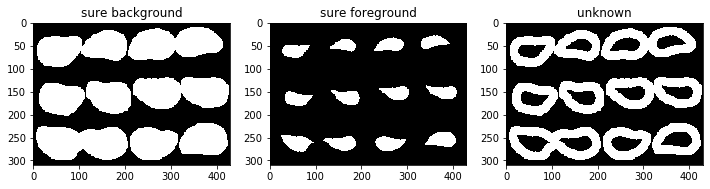

In [219]:
# 膨張させて，明確な背景(sure background)情報を得る
sure_bg = cv2.dilate(opening, kernel, iterations=2)

# 明確な前景(sure foreground)を出す
ret, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
print('閾値(距離変換で得られた値の最大値×0.5):', ret)

# 背景でも前景でもないunknownな境界部分を抽出
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

plt.figure(figsize=(12, 4))
plt.subplot(131); plt.imshow(sure_bg, cmap='gray'); plt.title('sure background')
plt.subplot(132); plt.imshow(sure_fg, cmap='gray'); plt.title('sure foreground')
plt.subplot(133); plt.imshow(unknown, cmap='gray'); plt.title('unknown')
plt.show()

before watershed : 
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int32), array([116315,   1206,   1450,   1048,   1289,   1402,   1410,   1394,
         1356,   1674,   1665,   1561,   1530], dtype=int64))
add unknown : 
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
      dtype=int32), array([52189, 64126,  1206,  1450,  1048,  1289,  1402,  1410,  1394,
        1356,  1674,  1665,  1561,  1530], dtype=int64))
after watershed : 
 (array([-1,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
      dtype=int32), array([ 4499, 71283,  4425,  4780,  4258,  4453,  4985,  4808,  4896,
        4706,  5229,  4912,  4964,  5102], dtype=int64))


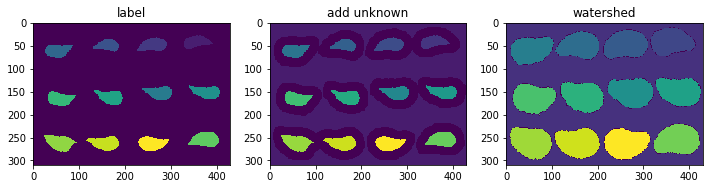

In [224]:
plt.figure(figsize=(12, 4))

# foregroundの1オブジェクトごとにラベリング
ret, markers = cv2.connectedComponents(sure_fg)
plt.subplot(131); plt.imshow(markers); plt.title('label')

# markersのデータの中身，0:背景 1以降:物体
print('before watershed : \n', np.unique(markers, return_counts=True))

# 0をunknown境界として用いるため，1を足して，1:背景 2以降:物体とする
markers += 1
markers[unknown == 255] = 0
plt.subplot(132); plt.imshow(markers); plt.title('add unknown')

# 0:unknown 1:背景 2以降:物体
print('add unknown : \n', np.unique(markers, return_counts=True))

# 各情報からwatershedを実行
markers = cv2.watershed(RoI, markers)
plt.subplot(133); plt.imshow(markers); plt.title('watershed')

# watershed実行後は-1:境界 1:背景 2以降:物体
print('after watershed : \n', np.unique(markers,return_counts=True))

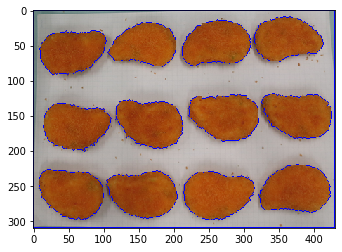

In [212]:
# 境界の領域を青で塗る
RoI[markers == -1] = [0, 0, 255]
plt.imshow(RoI)